This notebook will indicate:
1. how to load annotations from HALO/ASAP format annotation files;
2. how to serialize annotations to ASAP format annotation files;
3. how to transform annotations to masks and vice versa.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
import sys
sys.path.append("../")

## 1. Dataset preparation

In [4]:
!mkdir -p /tmp/annotations
!curl https://storage.googleapis.com/kidney_dataset/annotations/slide_001.halo.xml -o /tmp/annotations/slide_001.halo.xml
!ls /tmp/annotations/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  434k  100  434k    0     0  1119k      0 --:--:-- --:--:-- --:--:--     0-:-- 1116k
slide_001.asap.regen.xml  slide_001.asap.xml  slide_001.halo.xml


In [5]:
working_dir = Path("/tmp/annotations/")
halo_annotation_file = working_dir / "slide_001.halo.xml"

## 2. HALO annotation to ASAP annotation

In [6]:
from annotations import load_annotations_from_halo_xml, create_asap_annotation_file

In [7]:
annotations = load_annotations_from_halo_xml(halo_annotation_file)

In [8]:
asap_annotation_file = working_dir / "slide_001.asap.xml"
create_asap_annotation_file(annotations, asap_annotation_file)

In [9]:
!ls /tmp/annotations

slide_001.asap.regen.xml  slide_001.asap.xml  slide_001.halo.xml


The generated slide_001.asap.xml can now be used in ASAP to view the annotations.

## 3. Read directly from ASAP annotations

This functionality is needed, as later on, when models generate annotations, it will only be provided in ASAP format. 

In [10]:
from annotations import load_annotations_from_asap_xml

In [11]:
annotations = load_annotations_from_asap_xml(asap_annotation_file)

In [12]:
# the following dataframe is useful for rendering 
# different groups of annotations on ASAP and mask;
# can be modified according to the true annotation;
# must contain four columns: label, label_name, color and z-axis
# here it's directly decoded from HALO annotations.

label_info = pd.DataFrame({
    "label_name": ["Background"] + [a.group_name for a in annotations],
    "color": ["#000000"] + [a.render_color for a in annotations],
    "z-axis": 1
})
label_info = label_info.drop_duplicates().reset_index(drop=True)
label_info["label"] = label_info.index
label_info.loc[label_info["label_name"] == "Biopsy_core", "z-axis"] = 0
label_info = label_info.sort_values("z-axis")
label_info

,label_name,color,z-axis,label
1,Biopsy_core,#00ffff,0,1
0,Background,#000000,1,0
2,Glomerulus,#ff0000,1,2
3,Glomerulus_GS,#0000ff,1,3
4,Artery,#28614f,1,4
5,Arteriole,#59bb9b,1,5


## 4. Transformation between mask and annotation

In [13]:
from annotations import annotation_to_mask, mask_to_annotation, generate_colorful_mask

In [14]:
upper_left = (5000, 43000) # in level-0 coordinate system
level = 2
width, height = (30000 - upper_left[0]) // 4**level, (68000 - upper_left[1]) // 4**level
print(width, height)

1562 1562


The annotation to mask transformation is useful for training segmentation models.

In [15]:
mask = annotation_to_mask(annotations, label_info, upper_left, (width, height), level=level)

In [16]:
mask.shape, np.unique(mask)

((1562, 1562, 3), array([0, 1, 2, 3, 4, 5], dtype=uint8))

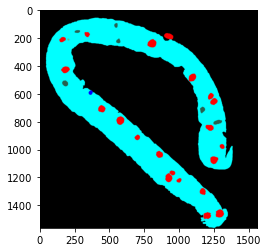

In [17]:
colorful_mask = generate_colorful_mask(mask, label_info)
plt.imshow(colorful_mask)

The inverse transformation is useful in rendering model inference results using polygons on ASAP.

In [18]:
regen_annotations = mask_to_annotation(mask, label_info, upper_left, level)

In [19]:
create_asap_annotation_file(regen_annotations, working_dir / "slide_001.asap.regen.xml")